<a href="https://colab.research.google.com/github/afortuny/DeepLearningFastAI/blob/main/DataMinining%20the%20Water%20Table.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#hide
! [ -e /content ] && pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 719 kB 5.1 MB/s 
     |████████████████████████████████| 62 kB 1.3 MB/s 
     |████████████████████████████████| 4.7 MB 65.0 MB/s 
     |████████████████████████████████| 1.3 MB 33.7 MB/s 
     |████████████████████████████████| 365 kB 78.7 MB/s 
     |████████████████████████████████| 141 kB 59.9 MB/s 
     |████████████████████████████████| 115 kB 73.1 MB/s 
     |████████████████████████████████| 101 kB 9.8 MB/s 
     |████████████████████████████████| 212 kB 52.4 MB/s 
     |████████████████████████████████| 596 kB 80.7 MB/s 
     |████████████████████████████████| 127 kB 49.0 MB/s 
     |████████████████████████████████| 6.6 MB 52.1 MB/s 
Mounted at /content/gdrive


In [2]:
#hide
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

#Pump it Up: Data Mining the Water Table
Using data from Taarifa and the Tanzanian Ministry of Water, can you predict which pumps are functional, which need some repairs, and which don't work at all? This is an intermediate-level practice competition. Predict one of these three classes based on a number of variables about what kind of pump is operating, when it was installed, and how it is managed. A smart understanding of which waterpoints will fail can improve maintenance operations and ensure that clean, potable water is available to communities across Tanzania. [competition link](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/23/)

## The Dataset

In [3]:
import pathlib 
path = pathlib.Path('/content/gdrive/MyDrive/Water')

In [4]:

Path.BASE_PATH = path

### Look at the Data

In [8]:
# load training data
df = pd.read_csv(path/'train.csv', low_memory=False)

In [9]:
# define target variable
dep_var = 'status_group'

In [10]:
# load test data for submission
df_test = pd.read_csv('/content/gdrive/MyDrive/Water/test.csv')

We are now ready to explore our first machine learning algorithm for tabular data: decision trees.

## First Model, random forests

In [39]:
procs = [Categorify, FillMissing]

`TabularPandas` needs to be told which columns are continuous and which are categorical. We can handle that automatically using the helper function `cont_cat_split`:

In [40]:
cont,cat = cont_cat_split(df, 1, dep_var=dep_var)

In [41]:
cont

['id',
 'amount_tsh',
 'gps_height',
 'longitude',
 'latitude',
 'num_private',
 'region_code',
 'district_code',
 'population',
 'construction_year']

In [42]:
del cont[0] # delete id

In [43]:
cat

['date_recorded',
 'funder',
 'installer',
 'wpt_name',
 'basin',
 'subvillage',
 'region',
 'lga',
 'ward',
 'public_meeting',
 'recorded_by',
 'scheme_management',
 'scheme_name',
 'permit',
 'extraction_type',
 'extraction_type_group',
 'extraction_type_class',
 'management',
 'management_group',
 'payment',
 'payment_type',
 'water_quality',
 'quality_group',
 'quantity',
 'quantity_group',
 'source',
 'source_type',
 'source_class',
 'waterpoint_type',
 'waterpoint_type_group']

In [44]:
splits = RandomSplitter(valid_pct=0.2)(range_of(df))

In [45]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var,splits=splits)

A `TabularPandas` behaves a lot like a fastai `Datasets` object, including providing `train` and `valid` attributes:

In [46]:
len(to.train),len(to.valid)

(47520, 11880)

We can see that the data is still displayed as strings for categories (we only show a few columns here because the full table is too big to fit on a page):

In [47]:
#hide_output
to.show(3)

,date_recorded,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,recorded_by,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,status_group
8137,4/6/2011,Government Of Tanzania,Government,Vitaliusi Mwakato,Lake Rukwa,Trm,Mbeya,Chunya,Makongorosi,True,GeoData Consultants Ltd,VWC,#na#,True,mono,mono,motorpump,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,0.0,0.0,33.163460,-8.419100,0.0,12,1,0.0,0.0,functional needs repair
18294,12/3/2013,Private Individual,Dmdd,Kambiya Fisi,Internal,Mende,Arusha,Karatu,Qurus,True,GeoData Consultants Ltd,VWC,Gyewasu,True,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,5.0,1472.0,35.635307,-3.393229,0.0,24,30,120.0,2002.0,functional
13628,10/12/2012,Rwssp,RWSSP,Serengeti,Internal,Busubi,Shinyanga,Shinyanga Rural,Didia,True,GeoData Consultants Ltd,WUG,#na#,True,other,other,other,wug,user-group,never pay,never pay,soft,good,enough,enough,other,other,unknown,other,other,0.0,0.0,33.068390,-3.806693,0.0,17,3,0.0,0.0,non functional


However, the underlying items are all numeric:

In [48]:
#hide_output
to.items.head(3)

,id,amount_tsh,date_recorded,funder,...,source_class,waterpoint_type,waterpoint_type_group,status_group
8137,19700.0,0.0,248,457,...,1,2,2,1
18294,17515.0,5.0,112,1273,...,2,2,2,0
13628,62266.0,0.0,39,1417,...,3,7,6,2


The conversion of categorical columns to numbers is done by simply replacing each unique level with a number. The numbers associated with the levels are chosen consecutively as they are seen in a column, so there's no particular meaning to the numbers in categorical columns after conversion. The exception is if you first convert a column to a Pandas ordered category, in which case the ordering you chose is used. We can see the mapping by looking at the `classes` attribute:

Since it takes a minute or so to process the data to get to this point, we should save it—that way in the future we can continue our work from here without rerunning the previous steps. fastai provides a `save` method that uses Python's *pickle* system to save nearly any Python object:

In [49]:
save_pickle(path/'to.pkl',to)

To read this back later, you would type:

```python
to = (path/'to.pkl').load()
```

Now that all this preprocessing is done, we are ready to create a decision tree.

### Creating the Decision Tree

To begin, we define our independent and dependent variables:

In [50]:
#hide
to = load_pickle(path/'to.pkl')

In [51]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

## Random Forests

### Creating a Random Forest

We will create random forest and see how it works on the validation test set.

In [52]:
from sklearn.ensemble import RandomForestClassifier

In [53]:
def rf(xs, y, n_estimators=100, max_samples=20000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [54]:
m = rf(xs, y);

In [55]:
yt_pre = m.predict(xs)
yv_pre = m.predict(valid_xs)

In [56]:
from sklearn.metrics import accuracy_score
accuracy_score(y, yt_pre)


0.8563341750841751

In [57]:
accuracy_score(valid_y, yv_pre)

0.8046296296296296

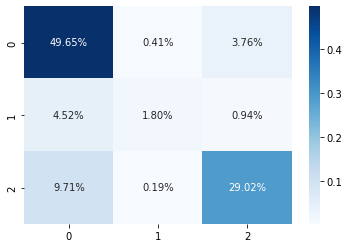

In [58]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(valid_y, yv_pre)
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')

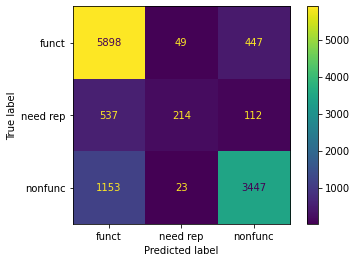

In [59]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['funct','need rep','nonfunc'])
disp.plot()
plt.show()

The following code snipped allow us to add the test set, processed and use it for predictions

In [62]:

to_tst = to.new(df_test)
to_tst.process()
to_tst.items.head()

,amount_tsh,date_recorded,funder,gps_height,...,source_type,source_class,waterpoint_type,waterpoint_type_group
0,0.0,0,308,1996.0,...,4,2,7,6
1,0.0,0,457,1569.0,...,7,1,2,2
2,0.0,0,0,1567.0,...,4,2,7,6
3,0.0,0,396,267.0,...,6,1,7,6
4,500.0,0,135,1260.0,...,7,1,2,2


In [63]:
m.predict(to_tst[xs.columns])

array([2, 0, 0, ..., 0, 0, 2], dtype=int8)

### Feature Importance

It's not normally enough just to know that a model can make accurate predictions—we also want to know *how* it's making predictions. *feature importance* gives us insight into this. We can get these directly from sklearn's random forest by looking in the `feature_importances_` attribute. Here's a simple function we can use to pop them into a DataFrame and sort them:

In [64]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

The feature importances for our model show that the first few most important columns have much higher importance scores than the rest, with the quantity of water and the location of the pump being the biggest predictors

In [66]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
24,quantity_group,0.110449
23,quantity,0.090907
32,longitude,0.069678
33,latitude,0.063304
28,waterpoint_type,0.052387
29,waterpoint_type_group,0.050270
0,date_recorded,0.039322
3,wpt_name,0.037967
5,subvillage,0.037746
38,construction_year,0.037614


A plot of the feature importances shows the relative importances more clearly:

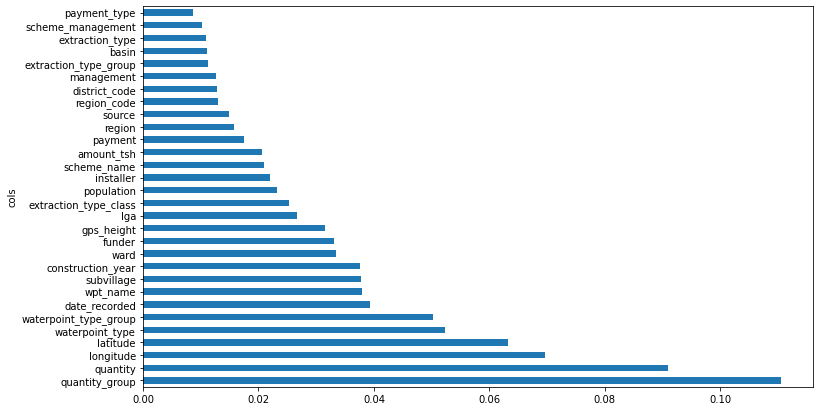

In [67]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

### Removing Low-Importance Variables

It seems likely that we could use just a subset of the columns by removing the variables of low importance and still get good results. Let's try just keeping those with a feature importance greater than 0.005:

In [80]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep)

31

We can retrain our model using just this subset of the columns:

In [81]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [82]:
m = rf(xs_imp, y)

And here's the result:

In [83]:
yt_pre = m.predict(xs_imp)
yv_pre = m.predict(valid_xs_imp)


In [84]:
accuracy_score(y, yt_pre)

0.8567340067340067

In [85]:
accuracy_score(valid_y, yv_pre)

0.805050505050505

Our accuracy is about the same, but we have far fewer columns to study:

In [86]:
len(xs.columns), len(xs_imp.columns)

(39, 31)

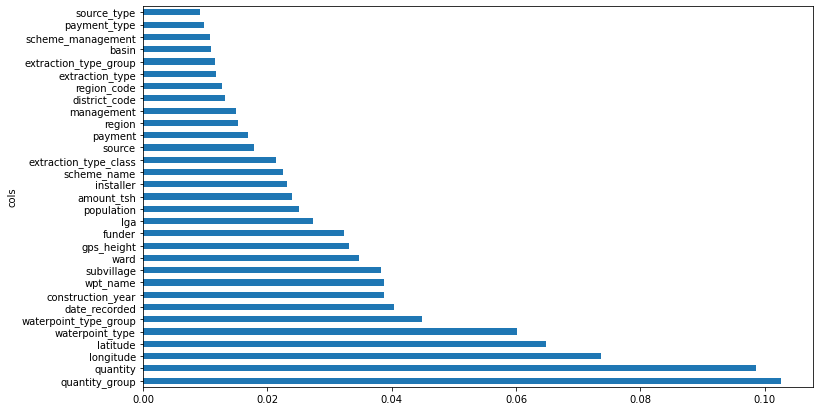

In [87]:
plot_fi(rf_feat_importance(m, xs_imp));

One thing that makes this harder to interpret is that there seem to be some variables with very similar meanings: for example, `GarageArea` and `GarageCars`. Let's try to remove any redundent features. 

### Removing Redundant Features

Let's start with:

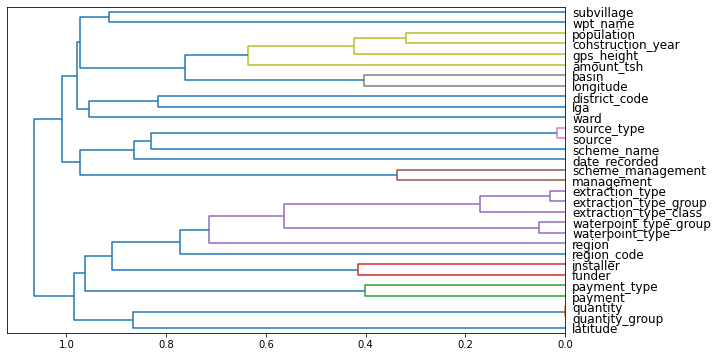

In [88]:
cluster_columns(xs_imp)

In this chart, the pairs of columns that are most similar are the ones that were merged together early, far from the "root" of the tree at the left. 

> note: Determining Similarity: The most similar pairs are found by calculating the _rank correlation_, which means that all the values are replaced with their _rank_ (i.e., first, second, third, etc. within the column), and then the _correlation_ is calculated. (Feel free to skip over this minor detail though, since it's not going to come up again in the book!)

Let's try removing some of these closely related features to see if the model can be simplified without impacting the accuracy. First, we create a function that quickly trains a random forest and returns the OOB score, by using a lower `max_samples` and higher `min_samples_leaf`. The OOB score is a number returned by sklearn that ranges between 1.0 for a perfect model and 0.0 for a random model. (In statistics it's called *R^2*, although the details aren't important for this explanation.) We don't need it to be very accurate—we're just going to use it to compare different models, based on removing some of the possibly redundant columns:

In [89]:
def get_oob(df):
    m = RandomForestClassifier(n_estimators=500, min_samples_leaf=15,
        max_samples=20000, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

Here's our baseline:

In [90]:
get_oob(xs_imp)

0.786489898989899

Now we try removing each of our potentially redundant variables, one at a time:

In [91]:
{c:get_oob(xs_imp.drop(c, axis=1)) for c in (
    'source_type','waterpoint_type','extraction_type')}

{'extraction_type': 0.7857744107744108,
 'source_type': 0.7869107744107744,
 'waterpoint_type': 0.7860900673400674}

Now let's try dropping multiple variables. We'll drop one from each of the tightly aligned pairs we noticed earlier. Let's see what that does:

In [92]:
to_drop = ['source_type','waterpoint_type','extraction_type']
get_oob(xs_imp.drop(to_drop, axis=1))

0.7843013468013468

In [96]:
m.predict(to_tst[xs_imp.columns])

array([2, 0, 2, ..., 0, 0, 2], dtype=int8)

##Neural Networks

### Using a Neural Network

We can use the same approach to build a neural network model. Let's first replicate the steps we took to set up the `TabularPandas` object:

In [97]:
df_nn = pd.read_csv(path/'train.csv', low_memory=False)

We can leverage the work we did to trim unwanted columns in the random forest by using the same set of columns for our neural network , plus high cardinality ones:

In [98]:
df_nn_final= df_nn[list(xs_imp.columns) + [dep_var]]

In [99]:
df_nn_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 32 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   quantity_group         59400 non-null  object 
 1   quantity               59400 non-null  object 
 2   longitude              59400 non-null  float64
 3   latitude               59400 non-null  float64
 4   waterpoint_type        59400 non-null  object 
 5   waterpoint_type_group  59400 non-null  object 
 6   date_recorded          59400 non-null  object 
 7   wpt_name               59400 non-null  object 
 8   subvillage             59029 non-null  object 
 9   construction_year      59400 non-null  int64  
 10  ward                   59400 non-null  object 
 11  funder                 55765 non-null  object 
 12  gps_height             59400 non-null  int64  
 13  lga                    59400 non-null  object 
 14  extraction_type_class  59400 non-null  object 
 15  po

In [100]:
cont_nn,cat_nn = cont_cat_split(df_nn_final, max_card=5, dep_var=dep_var)

In [101]:
cont_nn

['longitude',
 'latitude',
 'construction_year',
 'gps_height',
 'population',
 'amount_tsh',
 'region_code',
 'district_code']

Let's take a look at the cardinality of each of the categorical variables that we have chosen so far:

In [102]:
df_nn_final[cat_nn].nunique()

quantity_group             5
quantity                   5
waterpoint_type            7
waterpoint_type_group      6
date_recorded            356
                        ... 
basin                      9
extraction_type           18
scheme_management         12
payment_type               7
source_type                7
Length: 23, dtype: int64

We can create our `TabularPandas` object in the same way as when we created our random forest, with one very important addition: normalization. A random forest does not need any normalization—the tree building procedure cares only about the order of values in a variable, not at all about how they are scaled. But as we have seen, a neural network definitely does care about this. Therefore, we add the `Normalize` processor when we build our `TabularPandas` object:

In [103]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)

Tabular models and data don't generally require much GPU RAM, so we can use larger batch sizes:

In [104]:
dls = to_nn.dataloaders(128)

We can now create the `Learner` to create this tabular model. As usual, we use the application-specific learner function, to take advantage of its application-customized defaults. We set the loss function to MSE, since that's what this competition uses.

By default, for tabular data fastai creates a neural network with two hidden layers, with 200 and 100 activations, respectively. This works quite well for small datasets, but here we've got quite a large dataset, so we increase the layer sizes to 500 and 250:

In [116]:
learn = tabular_learner(dls, layers=[700,250], metrics=accuracy)

SuggestedLRs(valley=0.0004786300996784121)

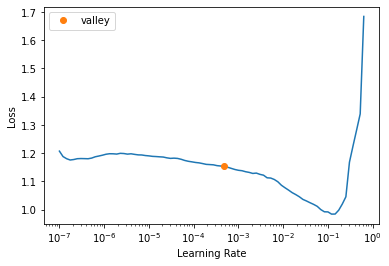

In [117]:
learn.lr_find()

There's no need to use `fine_tune`, so we'll train with `fit_one_cycle` for a few epochs and see how it looks:

In [118]:
learn.fit_one_cycle(1, 0.0004,wd=0.25)

epoch,train_loss,valid_loss,accuracy,time
0,0.585405,0.564657,0.785185,00:05


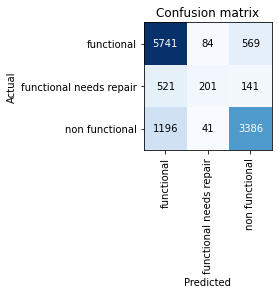

In [119]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [120]:
df_test = pd.read_csv('/content/gdrive/MyDrive/Water/test.csv')

In [121]:
del (df_test['id'])

In [122]:
to_test = TabularPandas(df_test, procs, cat_nn, cont_nn)

In [123]:
test_dl = dls.test_dl(df_test, with_labels=False)

In [124]:
preds = learn.get_preds(dl=test_dl)

In [125]:
import pandas as pd
#preds[0]

pada = pd.DataFrame(preds[0]).astype("float")

In [126]:
pada['pred'] = pada.apply(lambda x: x.argmax(), axis=1)

In [127]:
pada['pred'].value_counts()

0    9587
2    4927
1     336
Name: pred, dtype: int64

In [137]:
pada.columns = ['0','1','2','pred']

In [138]:
df_test_id = pd.read_csv('/content/gdrive/MyDrive/Water/test.csv')

In [139]:
df_test_id =  pd.concat([df_test_id, pada],axis=1)

In [140]:
submission = pd.read_csv('/content/gdrive/MyDrive/Water/SubmissionFormat.csv')

In [141]:
df_test_id = pd.merge(df_test_id,submission,on = 'id' )

In [142]:
df_test_id.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', '0', '1', '2', 'pred', 'status_group'],
      dtype='object')

In [143]:
df_test_id.loc[df_test_id['pred'] == 0, 'status_group'] = 'functional'
df_test_id.loc[df_test_id['pred'] == 1, 'status_group'] = 'functional needs repair'
df_test_id.loc[df_test_id['pred'] == 2, 'status_group'] = 'non functional'

In [144]:
df_test_id['status_group'].value_counts()

functional                 9587
non functional             4927
functional needs repair     336
Name: status_group, dtype: int64

In [146]:
df_test_id['rf'] = np.nan

In [147]:
df_test_id.loc[:,'rf'] = m.predict(to_tst[xs_imp.columns])

In [148]:
df_test_id['status_group'].value_counts()

functional                 9587
non functional             4927
functional needs repair     336
Name: status_group, dtype: int64

In [149]:
df_test_id.to_csv('solution.csv')

By using only the NN when is 60% certain I reach 79%, which is only 3pp from state of the art